<a href="https://colab.research.google.com/github/OdysseusPolymetis/humanistica2023/blob/main/humanistica2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Détection de Similarité pour le Grec Ancien**</center>

Requirements

In [2]:
!pip install torch transformers numpy scipy stanza python-Levenshtein rank_bm25 faiss-gpu bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 113.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB

Récupération du modèle Ancient Greek Bert

In [3]:
from transformers import AutoTokenizer, AutoModel
tokeniser = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

Récupération des treebank data

In [4]:
!git clone https://github.com/PerseusDL/treebank_data.git

Cloning into 'treebank_data'...
remote: Enumerating objects: 2633, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 2633 (delta 143), reused 214 (delta 141), pack-reused 2411
Receiving objects: 100% (2633/2633), 75.59 MiB | 29.82 MiB/s, done.
Resolving deltas: 100% (1498/1498), done.
Updating files: 100% (289/289), done.


Récupération des stopwords

In [5]:
!gdown --id 1MZ4ld8j30ye3YGYy-T7V3Cyy1c4dlGks

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MZ4ld8j30ye3YGYy-T7V3Cyy1c4dlGks
To: /content/stopwords_gk.txt
100% 98.3k/98.3k [00:00<00:00, 100MB/s]


Pour enlever les accents

In [6]:
def remove_diacritics(char):
    normalized_char = unicodedata.normalize('NFD', char)
    non_diacritic_char = ''.join(c for c in normalized_char if not unicodedata.combining(c))
    return non_diacritic_char

Pour créer une liste de stopwords sans accents

In [7]:
import unicodedata
stopwords=[]
with open("/content/stopwords_gk.txt", encoding = "utf8") as stop_file:
  stopwords_diacritics=stop_file.read().split("\n")
stopwords_diacritics=set(stopwords_diacritics)
stopwords=set()
for stopword in stopwords_diacritics:
  stopword_no_diac=remove_diacritics(stopword)
  stopwords.add(stopword_no_diac)


Les imports

In [8]:
import string
import xml.etree.ElementTree as ET
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
import Levenshtein as lev
from sklearn.metrics.pairwise import cosine_similarity
import glob
from itertools import product
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
import string
from collections import defaultdict
import math
import pandas as pd
import plotly.figure_factory as ff
import os
import gc
import numpy as np

Vérifications de la GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
if torch.cuda.is_available():
    model = model.to('cuda')

Sortie pour les écoutes d'attention

In [ ]:
output_dir = "/content/attentions"

# Créez le répertoire s'il n'existe pas déjà
os.makedirs(output_dir, exist_ok=True)

Preprocessing du texte : basse casse et sans ponctuation

In [11]:
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

Distance de Jaro-Winkler

In [12]:
def jaro_winkler_similarity(s1, s2, stopwords):
    words1 = s1.split()
    words2 = s2.split()

    # Initialiser le score max à 0
    max_score = 0

    # Calculer la distance de Jaro-Winkler pour chaque paire de mots
    for word1 in words1:
        for word2 in words2:
            word1=remove_diacritics(word1)
            word2=remove_diacritics(word2)
            if len(word1) > 5 and len(word2) > 5 and word1 not in stopwords and word2 not in stopwords:
                score = lev.jaro_winkler(word1, word2)
                if score < 0.8 :
                  score = 0
                if score > max_score:
                    max_score = score

    return max_score

Liste de lemmes communs suivis

In [13]:
def count_consecutive_common_lemmas(sentence1, sentence2, stopwords):
    lemmas1 = [word for word in sentence1.split() if word not in stopwords]
    lemmas2 = [word for word in sentence2.split() if word not in stopwords]

    count = 0
    min_len = min(len(lemmas1), len(lemmas2))

    for i in range(min_len):
        if lemmas1[i] == lemmas2[i]:
            count += 1
        else:
            break
    return count

Récupération des données d'attention

In [13]:
def load_attention_info(file_prefix):
    # Chercher tous les fichiers qui commencent par 'file_prefix'
    files = glob.glob(f"{file_prefix}*.pickle")

    attention_info_all = []
    for file in sorted(files): # pour garder le même ordre
        with open(file, 'rb') as f:
            attention_info_batch = pickle.load(f)
            attention_info_all.extend(attention_info_batch)

    return attention_info_all

Paramétrage des graphes d'attention

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_attention(attention, sentence, important_words, filename, i, ax):
    important_attention = []
    important_word_list = []

    for word, scores in zip(sentence.split(), attention):
        if word in important_words:
            important_attention.append(scores.mean().cpu().item())
            important_word_list.append(word)

    important_attention = np.array(important_attention)
    important_attention = (important_attention - important_attention.min()) / (important_attention.max() - important_attention.min() + 1e-9)

    img = ax.imshow(important_attention.reshape(1, -1), cmap='plasma', interpolation='nearest', vmin=0, vmax=1)
    ax.set_yticks([])
    ax.set_xticks(range(len(important_word_list)))
    ax.set_xticklabels(important_word_list, rotation='vertical')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(img, cax=cax)

Création des graphes d'attention

In [ ]:
def visualize_attention(attention_info, filename):
    if not os.path.exists('/content/attention_graphs/'):
        os.makedirs('/content/attention_graphs/')

    num_sentences = len(attention_info)
    #num_sentences = 20
    max_sentences_per_fig = 5  # Maximum number of sentences per figure
    dpi = 100

    for fig_num in range(num_sentences // max_sentences_per_fig + 1):
        #print(f'figure {fig_num}')
        start = fig_num * max_sentences_per_fig
        end = start + max_sentences_per_fig
        fig_sentences = attention_info[start:end]

        if not fig_sentences:
            continue  # Skip if fig_sentences is empty

        fig, axs = plt.subplots(len(fig_sentences), 1, figsize=(10, len(fig_sentences) * 3), dpi=dpi)
        if len(fig_sentences) == 1:  # If there's only one sentence, axs is not a list, so make it a list
            axs = [axs]

        for i, info in enumerate(fig_sentences):
            #print(f'sentence {i}')
            plot_attention(info["attention"], info["sentence"], info["important_words"], filename, i, axs[i])

        plt.subplots_adjust(hspace=2)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"/content/attention_graphs/{os.path.basename(filename)}_{fig_num}.png", dpi=dpi)
        plt.close()



Brassage du TF-IDF global (on peut exclure des auteurs)

In [14]:
def read_all(files):

  print("Reading the whole corpus for TF-IDF")

  term_frequencies = defaultdict(lambda: defaultdict(int))
  document_frequencies = defaultdict(set)
  inverse_document_frequencies = {}

  excluded=["tlg0011.", "tlg0085."]

  num_documents = 0

  for filename in files:
    if not any(excluded_string in filename for excluded_string in excluded):
      print(f'File being processed for TF-IDF : {filename}')
      tree = ET.parse(filename) # lire le fichier XML
      root = tree.getroot()  # obtenir la racine de l'arbre XML
      num_documents +=1

        # Parcourir chaque sentence dans le fichier
      for sentence in root.iter('sentence'):
            # créer un ensemble pour stocker les lemmas uniques dans cette sentence
        sentence_lemmas = set()
            # Parcourir chaque word dans la sentence
        for word in sentence.iter('word'):
          lemma = word.get('lemma')
          if lemma is not None:
            lemma = preprocess_text(lemma)
            lemma = ''.join(remove_diacritics(char) for char in lemma)
                    # Si ce n'est pas un stopwords
            if lemma not in stopwords:
                        # mettre à jour la fréquence du terme pour ce document
              term_frequencies[lemma][filename] += 1
              sentence_lemmas.add(lemma)

            # mettre à jour les fréquences de documents pour chaque lemma unique dans la sentence
        for lemma in sentence_lemmas:
          document_frequencies[lemma].add(filename)

  for lemma, documents in document_frequencies.items():
    #print(f'Lemma: {lemma}, Document Frequencies: {len(documents)}')
    inverse_document_frequencies = {lemma: math.log(num_documents / len(documents)) for lemma, documents in document_frequencies.items()}

  return inverse_document_frequencies


**Avec BATCH**
<br>Ramassage des lemmes, constitution des embeddings pour chaque texte, ramassage des scores TF-IDF
<br>Prend de 5 à 10 minutes avec les stopwords
<br>Pour faire tourner BERT sur du non lemmatisé, lui passer form_sentences à la place de sentences



In [16]:
def process_file(filename, inverse_document_frequencies, is_source_file=True):

  print(f'Lecture du fichier en cours : {filename}\n')
  tree = ET.parse(filename)
  root = tree.getroot()
  sentences = []
  form_sentences = []
  tfidf_threshold=0.6

  for sentence in root.iter('sentence'):
    forms = []
    lemmas = []
    for word in sentence.iter('word'):
        lemma = word.get('lemma')
        form = word.get('form')
        if lemma is not None:
            lemma = preprocess_text(lemma)
            lemma = ''.join(remove_diacritics(char) for char in lemma)
            lemmas.append(lemma)
            forms.append(form)

    if len(lemmas)==0:
      print("potentielle phrase vide")

    form_sentences.append(' '.join(forms))
    sentences.append(' '.join(lemmas))

  embeddings = []
  batch_size = 256
  attention_info = []

  print("Calcul des embeddings en cours (avec attention)\n")

  for i in range(0, len(sentences), batch_size):
    batch_sentences = form_sentences[i:i+batch_size]
    inputs = tokeniser(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = inputs.to(model.device)
    with torch.no_grad():
      outputs = model(**inputs, output_attentions=True)
    embeddings.extend(outputs[0].mean(dim=1).cpu().numpy())

    for sentence, attention in zip(batch_sentences, outputs.attentions):
        word_scores = {word: inverse_document_frequencies.get(word, 0) for word in sentence.split()}
        important_words = sorted(word_scores, key=word_scores.get, reverse=True)[:10]
        important_word_indices = [i for i, word in enumerate(sentence.split()) if word in important_words]
        attention = outputs.attentions[-1][0, :, important_word_indices, :]
        attention_info.append({"sentence": sentence, "attention": attention, "important_words": important_words})

    # Save attention info for important words only
    with open(f"/content/attentions/attention_info_{os.path.basename(filename)}_{i//batch_size}.pickle", "wb") as f:
      pickle.dump(attention_info, f)

    visualize_attention(attention_info, filename)

    del inputs
    del outputs
    torch.cuda.empty_cache()

  print("Calcul du TF-IDF des fichiers\n")

  if is_source_file:
    tokenized_corpus = [sentence.split() for sentence in sentences]
    max_idf = max(inverse_document_frequencies.values())
    normalized_scores = {lemma: inverse_document_frequencies.get(lemma, 0) / max_idf for sentence in tokenized_corpus for lemma in sentence if lemma not in stopwords}

  else:
    normalized_scores = {}


  return filename, sentences, form_sentences, embeddings, normalized_scores

Fonction sans les fichiers de sortie d'attention (prend beaucoup de RAM)

In [15]:
def process_file_without_attention(filename, inverse_document_frequencies, is_source_file=True):

  print(f'Lecture du fichier en cours : {filename}\n')
  tree = ET.parse(filename)
  root = tree.getroot()
  sentences = []
  form_sentences = []
  form_sentences_for_emb = []
  tfidf_threshold=0.6

  for sentence in root.iter('sentence'):
    forms_for_emb = []
    forms = []
    lemmas = []
    for word in sentence.iter('word'):
        lemma = word.get('lemma')
        form = word.get('form')
        if lemma is not None:
            lemma = preprocess_text(lemma)
            lemma = ''.join(remove_diacritics(char) for char in lemma)
            lemmas.append(lemma)
            forms.append(form)
            form = ''.join(remove_diacritics(char) for char in form)
            forms_for_emb.append(form)

    if len(lemmas)==0:
      print("potentielle phrase vide")

    form_sentences_for_emb.append(' '.join(forms_for_emb))
    form_sentences.append(' '.join(forms))
    sentences.append(' '.join(lemmas))

  embeddings = []
  batch_size = 256
  attention_info = []

  print("Calcul des embeddings en cours (avec attention)\n")

  for i in range(0, len(sentences), batch_size):
    batch_sentences = form_sentences_for_emb[i:i+batch_size]
    inputs = tokeniser(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = inputs.to(model.device)
    with torch.no_grad():
      outputs = model(**inputs, output_attentions=True)
    embeddings.extend(outputs[0].mean(dim=1).cpu().numpy())

    del inputs
    del outputs
    torch.cuda.empty_cache()

  print("Calcul du TF-IDF des fichiers\n")

  if is_source_file:
    tokenized_corpus = [sentence.split() for sentence in sentences]
    max_idf = max(inverse_document_frequencies.values())
    normalized_scores = {lemma: inverse_document_frequencies.get(lemma, 0) / max_idf for sentence in tokenized_corpus for lemma in sentence if lemma not in stopwords}

  else:
    normalized_scores = {}


  return filename, sentences, form_sentences, embeddings, normalized_scores

**FAITH OPTIMIZED**
<br>Calcul de similarité des vecteurs avec faiss, et constitution du score de similarité global

In [16]:
import faiss
import numpy as np

def compare_files(data1, data2):
    filename1, sentences1, form_sentences1, embeddings1, normalized_scores1 = data1
    filename2, sentences2, form_sentences2, embeddings2, normalized_scores2 = data2

    print(f'Files {filename1} and {filename2} are being compared\n')
    print('Calcul de similarité des embeddings avec faiss en cours\n')


    embeddings1 = np.array(embeddings1)
    embeddings2 = np.array(embeddings2)

    faiss.normalize_L2(embeddings1)
    faiss.normalize_L2(embeddings2)

    index = faiss.IndexFlatIP(embeddings2.shape[1])   # IP = Inner Product
    index.add(embeddings2)

    _, indices = index.search(embeddings1, 1)

    sentence_pairs_and_scores = [(sentence1, sentences2[i], cosine_similarity([emb1], [embeddings2[i]])[0, 0])
                             for emb1, sentence1, i in zip(embeddings1, sentences1, indices.flatten())]

    sentence_pairs_and_scores.sort(key=lambda x: x[2], reverse=True)

    del embeddings1
    del embeddings2
    gc.collect()
    del index
    gc.collect()

    print('Calcul du score de similarité\n')

    global_similarity_scores = []
    tfidf_threshold = 0.7
    pushup_score = 0.1
    for sentence1, sentence2, cosine_similarity_score in sentence_pairs_and_scores:
        form_sentence1 = form_sentences1[sentences1.index(sentence1)]
        form_sentence2 = form_sentences2[sentences2.index(sentence2)]
        common_lemmas = set(sentence1.split()).intersection(set(sentence2.split())) - set(stopwords)
        common_lemmas_count = len(common_lemmas)
        common_tfidf_scores_sentences1 = [(lemma, normalized_scores1.get(lemma, 0)) for lemma in common_lemmas]

        max_tfidf_score_sentences1 = max(score for _, score in common_tfidf_scores_sentences1) if common_tfidf_scores_sentences1 else 0

        if len(sentence1.split()) < 4 and max_tfidf_score_sentences1 > tfidf_threshold:
            global_similarity_score = (cosine_similarity_score + max_tfidf_score_sentences1)/2
        elif max_tfidf_score_sentences1 > tfidf_threshold:
            jw_similarity_score = jaro_winkler_similarity(sentence1, sentence2, stopwords)
            if common_lemmas_count > 1:
              global_similarity_score = ((cosine_similarity_score + jw_similarity_score*common_lemmas_count + max_tfidf_score_sentences1) / (2 + common_lemmas_count))+pushup_score
            else:
              global_similarity_score = (cosine_similarity_score + jw_similarity_score+ max_tfidf_score_sentences1) / 3
        else:
            global_similarity_score = cosine_similarity_score-0.1

        global_similarity_scores.append((form_sentence1, form_sentence2, global_similarity_score, common_lemmas))

    global_similarity_scores.sort(key=lambda x: x[2], reverse=True)

    similarity_scores = [score for _, _, score, _ in global_similarity_scores]
    similarity_mean = sum(similarity_scores) / len(similarity_scores)

    return filename1, filename2, similarity_mean, global_similarity_scores


Appel des fonctions de prétraitement et de TF-IDF

In [17]:
files = glob.glob('/content/treebank_data/v2.1/Greek/texts/*.xml')

# Identification des étiquettes source et cibles
source_tags = ["tlg0012"]
target_tags = ["tlg0011", "tlg0085"]  # Ajoutez d'autres étiquettes si nécessaire

# Division des fichiers en source et cible basés sur les étiquettes dans leurs noms
source_files = [file for file in files if any(tag in file for tag in source_tags)]
target_files = [file for file in files if any(tag in file for tag in target_tags)]

inverse_document_frequencies = read_all(files)

with open('/content/tfidf.pkl', 'wb') as fichier:
    # utiliser pickle.dump pour sauvegarder la variable dans le fichier
    pickle.dump(inverse_document_frequencies, fichier)


Reading the whole corpus for TF-IDF
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0059.tlg001.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0008.tlg001.perseus-grc1.12.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0013.tlg002.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0003.tlg001.perseus-grc1.1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0540.tlg014.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0020.tlg002.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0007.tlg015.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0540.tlg015.perseus-grc1.tb.xml
File being processed for TF-IDF : /content/treebank_data/v2.1/Greek/texts/tlg0007.tlg00

Appel des fonctions de création des embeddings et des graphes d'attention

In [18]:
source_data = [process_file_without_attention(file, inverse_document_frequencies, True) for file in source_files]
target_data = [process_file_without_attention(file, inverse_document_frequencies, False) for file in target_files]


with open('/content/source_data.pkl', 'wb') as fichier:
    # utiliser pickle.dump pour sauvegarder la variable dans le fichier
    pickle.dump(source_data, fichier)

with open('/content/target_data.pkl', 'wb') as fichier:
    # utiliser pickle.dump pour sauvegarder la variable dans le fichier
    pickle.dump(target_data, fichier)

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml

Calcul des embeddings en cours (avec attention)

Calcul du TF-IDF des fichiers

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg001.perseus-grc1.tb.xml

Calcul des embeddings en cours (avec attention)

Calcul du TF-IDF des fichiers

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/tlg0011.tlg005.perseus-grc2.tb.xml

Calcul des embeddings en cours (avec attention)

Calcul du TF-IDF des fichiers

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/tlg0011.tlg004.perseus-grc1.tb.xml

Calcul des embeddings en cours (avec attention)

Calcul du TF-IDF des fichiers

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/tlg0085.tlg004.perseus-grc2.tb.xml

Calcul des embeddings en cours (avec attention)

Calcul du TF-IDF des fichiers

Lecture du fichier en cours : /content/treebank_data/v2.1/Greek/texts/

Appel des fonction de comparaison des textes, avec scores de similarité

In [19]:
# Maintenant, on compare chaque fichier source à chaque fichier cible
file_similarity_scores = []

for data1, data2 in product(source_data, target_data):
    score_info=compare_files(data1, data2)
    file_similarity_scores.append(score_info)

Files /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml and /content/treebank_data/v2.1/Greek/texts/tlg0011.tlg005.perseus-grc2.tb.xml are being compared

Calcul de similarité des embeddings avec faiss en cours

Calcul du score de similarité

Files /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml and /content/treebank_data/v2.1/Greek/texts/tlg0011.tlg004.perseus-grc1.tb.xml are being compared

Calcul de similarité des embeddings avec faiss en cours

Calcul du score de similarité

Files /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml and /content/treebank_data/v2.1/Greek/texts/tlg0085.tlg004.perseus-grc2.tb.xml are being compared

Calcul de similarité des embeddings avec faiss en cours

Calcul du score de similarité

Files /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml and /content/treebank_data/v2.1/Greek/texts/tlg0085.tlg003.perseus-grc2.tb.xml are being compared

Calcul de simila

Sauvegarde des scores

In [20]:
with open('/content/unsorted_similarity_score.pkl', 'wb') as fichier:
    # utiliser pickle.dump pour sauvegarder la variable dans le fichier
    pickle.dump(file_similarity_scores, fichier)

Vérification des scores

In [21]:
files_with_zero_score = []

for filename1, filename2, max_score, score in file_similarity_scores:
    if max_score == 0:
        files_with_zero_score.append((filename1, filename2))

if len(files_with_zero_score) > 0:
    print("Les fichiers suivants ont des scores de comparaison à zéro, quelque chose ne va pas :")
    for filename1, filename2 in files_with_zero_score:
        print(f"- {filename1} et {filename2}")
else:
    print("Aucun fichier n'a de score de comparaison à zéro.")


Aucun fichier n'a de score de comparaison à zéro.


Fonction de création d'une carte de chaleur de similarité globale

In [22]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(source_files, target_files, file_similarity_scores):
    # Créer un dictionnaire pour stocker les scores de similarité par fichier source
    similarity_scores_by_source = {}

    # Parcourir les scores de similarité pour chaque paire de fichiers
    for filename1, filename2, max_score, _ in file_similarity_scores:
        # Vérifier si le fichier source existe dans le dictionnaire
        if filename1 not in similarity_scores_by_source:
            similarity_scores_by_source[filename1] = []

        # Ajouter le score de similarité à la liste correspondante
        similarity_scores_by_source[filename1].append((filename2, max_score))

    # Trier les scores de similarité par ordre décroissant pour chaque fichier source
    for filename in similarity_scores_by_source:
        similarity_scores_by_source[filename].sort(key=lambda x: x[1], reverse=True)

    # Parcourir les fichiers source et créer une heatmap pour chaque fichier
    for source_file in source_files:
        # Récupérer les scores de similarité triés pour le fichier source
        sorted_scores = similarity_scores_by_source[source_file]

        # Obtenir les étiquettes des fichiers cibles en utilisant os.path.basename
        target_labels = [os.path.basename(filename2) for filename2, _ in sorted_scores]

        source_file_basename = os.path.basename(source_file)

        # Créer la heatmap pour le fichier source
        plt.figure(figsize=(8, 6))
        sns.heatmap([[score] for _, score in sorted_scores], xticklabels=['Similarity Score'], yticklabels=[os.path.basename(filename2) for filename2, _ in sorted_scores], cmap="YlGnBu", cbar_kws={'label': 'Similarity Score'}, square=True, annot=True, fmt=".2f", linewidths=0.5, linecolor='lightgray', annot_kws={"fontsize": 8}, cbar=True, cbar_ax=None, ax=None)
        plt.title(f'Similarity Heatmap for {source_file_basename}')
        plt.ylabel('Target Files')
        plt.show()


Appel de la fonction de création de carte de chaleur

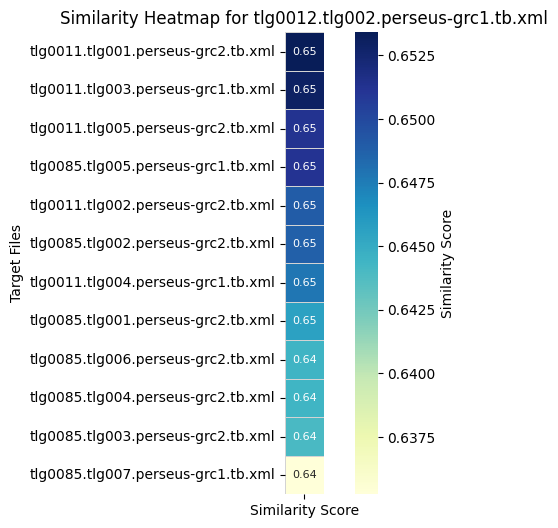

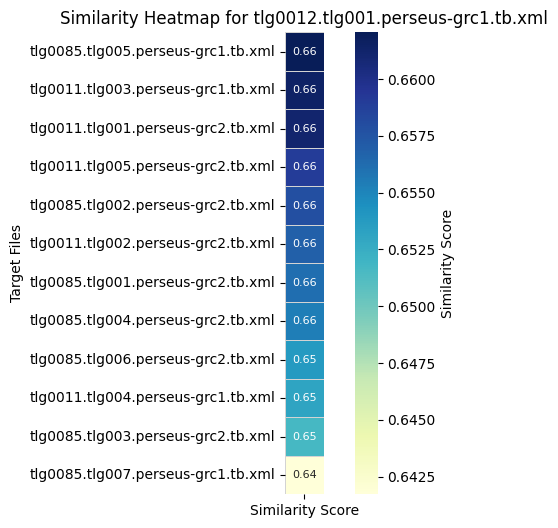

In [23]:
create_heatmap(source_files, target_files, file_similarity_scores)

Création d'une DataFrame interrogeable

In [24]:
import pandas as pd

# Créer une liste pour stocker les données des phrases similaires
similar_sentences_data = []

# Parcourir la liste des objets score_info
for score_info in file_similarity_scores:
    source_file = score_info[0]
    target_file = score_info[1]
    average_score = score_info[2]
    sentences_data = score_info[3]

    # Parcourir les données des phrases similaires
    for sentence_data in sentences_data:
        source_sentence = sentence_data[0]
        target_sentence = sentence_data[1]
        similarity_score = sentence_data[2]
        common_lemmas = sentence_data[3]

        # Ajouter les données à la liste des phrases similaires
        similar_sentences_data.append({
            'Source File': source_file,
            'Target File': target_file,
            'Average Score': average_score,
            'Source Sentence': source_sentence,
            'Target Sentence': target_sentence,
            'Similarity Score': similarity_score,
            'Common Lemmas': common_lemmas
        })

# Créer un DataFrame à partir des données des phrases similaires
similar_sentences_df = pd.DataFrame(similar_sentences_data)


Impression généraliste de la DataFrame

In [25]:
for filename1, filename2, max_score, score_info in file_similarity_scores:
    print(f"Similarity scores for {filename1} and {filename2}:")
    top_scores = sorted(score_info, key=lambda x: x[2], reverse=True)[:10]
    for sentence1, sentence2, score, common_lemmas in top_scores:
        print(f"Sentence 1: {sentence1}")
        print(f"Sentence 2: {sentence2}")
        print(f"Similarity Score: {score}")
        print(f"Common Lemmas: {common_lemmas}")
        print()


Similarity scores for /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml and /content/treebank_data/v2.1/Greek/texts/tlg0011.tlg005.perseus-grc2.tb.xml:
Sentence 1: τῷ δέ οἱ ὀγδοάτῳ κακὸν ἤλυθε δῖος Ὀρέστης ἂψ ἀπ̓ Ἀθηνάων , κατὰ δ̓ ἔκτανε πατροφονῆα , Αἴγισθον δολόμητιν , ὅ οἱ πατέρα κλυτὸν ἔκτα .
Sentence 2: τὰ δὲ παννυχίδων ἤδη στυγεραὶ ξυνίσασ̓ εὐναὶ μογερῶν οἴκων , ὅσα τὸν δύστηνον ἐμὸν θρηνῶ πατέῤ , ὃν κατὰ μὲν βάρβαρον αἶαν φοίνιος Ἄρης οὐκ ἐξένισεν , μήτηρ δ̓ ἡμὴ χὠ κοινολεχὴς Αἴγισθος ὅπως δρῦν ὑλοτόμοι σχίζουσι κάρα φονίῳ πελέκει , κοὐδεὶς τούτων οἶκτος ἀπ̓ ἄλλης ἢ ̓ μοῦ φέρεται , σοῦ , πάτερ , οὕτως αἰκῶς οἰκτρῶς τε θανόντος .
Similarity Score: 1.0338296353816987
Common Lemmas: {'πατηρ', 'αιγισθος'}

Sentence 1: ἀλλ̓ ὅτε δὴ τάχ̓ ἔμελλε Μαλειάων ὄρος αἰπὺ ἵξεσθαι , τότε δή μιν ἀναρπάξασα θύελλα πόντον ἐπ̓ ἰχθυόεντα φέρεν βαρέα στενάχοντα , ἀγροῦ ἐπ̓ ἐσχατιήν , ὅθι δώματα ναῖε Θυέστης τὸ πρίν , ἀτὰρ τότ̓ ἔναιε Θυεστιάδης Αἴγισθος .
Sentence 2: τὰ δὲ παν

Graphe de Sankey

In [ ]:
import plotly.graph_objects as go
import os
import itertools

# Générez un ensemble de labels pour les phrases (par exemple 'A', 'B', 'C', etc.)
import string
phrase_labels = iter(''.join(chars) for chars in itertools.product(string.ascii_uppercase, repeat=2))

# Préparez les données pour le diagramme Sankey
sources = []
targets = []
values = []
labels = []
hovertexts = []

legend_data = []

for file_score_info in file_similarity_scores:
    source_file, target_file, mean_score, global_similarity_scores = file_score_info

    source_file = os.path.basename(source_file)
    target_file = os.path.basename(target_file)

    if source_file not in labels:
        labels.append(source_file)

    if target_file not in labels:
        labels.append(target_file)

    sources.append(labels.index(source_file))
    targets.append(labels.index(target_file))
    values.append(mean_score)

    # Pour chaque paire de fichiers, prenez les trois phrases les plus similaires
    for sentence1, sentence2, score, _ in global_similarity_scores[:3]:
        phrase_label = next(phrase_labels)
        labels.append(phrase_label)

        sources.append(labels.index(source_file))
        targets.append(labels.index(phrase_label))
        values.append(score)

        sources.append(labels.index(phrase_label))
        targets.append(labels.index(target_file))
        values.append(score)

        hovertexts.append(f"{source_file} -> {phrase_label}: {sentence1}")
        hovertexts.append(f"{phrase_label} -> {target_file}: {sentence2}")

        legend_data.append((phrase_label, sentence1, sentence2))

# Création de la légende
legend = go.Table(header=dict(values=['Label', 'Source Sentence', 'Target Sentence']),
                  cells=dict(values=[list(i) for i in zip(*legend_data)]))

fig = go.Figure()

fig.add_trace(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=sources,  # indices correspondant à labels, définissant les sources des liens
        target=targets,  # indices correspondant à labels, définissant les cibles des liens
        value=values  # valeur des liens
    )))

fig.update_layout(title_text="Sankey Diagram of Sentence Similarities", font_size=10)
fig.show()

legend = go.Figure(data=[go.Table(header=dict(values=['Label', 'Source Sentence', 'Target Sentence']),
                  cells=dict(values=[list(i) for i in zip(*legend_data)]))])
legend.show()



Fonction pour la recherche de suite de lemmes dans le corpus source

In [27]:
def search_lemma_sequence_in_similarity_scores(file_similarity_scores, lemma_sequence):
    results = []

    # Parcourir la liste des objets score_info
    for score_info in file_similarity_scores:
        source_file = score_info[0]
        target_file = score_info[1]
        average_score = score_info[2]
        sentences_data = score_info[3]

        # Parcourir les données des phrases similaires
        for sentence_data in sentences_data:
            source_sentence = sentence_data[0]
            target_sentence = sentence_data[1]
            similarity_score = sentence_data[2]
            common_lemmas = sentence_data[3]

            # Vérifier si la séquence de lemmes est dans la phrase source
            if lemma_sequence in source_sentence:
                # Ajouter les données à la liste des résultats
                results.append({
                    'Source File': source_file,
                    'Target File': target_file,
                    'Average Score': average_score,
                    'Source Sentence': source_sentence,
                    'Target Sentence': target_sentence,
                    'Similarity Score': similarity_score,
                    'Common Lemmas': common_lemmas
                })

    # Trier les résultats par Similarity Score de façon décroissante
    results.sort(key=lambda x: x['Similarity Score'], reverse=True)

    return results


Interface d'interrogation du corpus source

In [28]:
import ipywidgets as widgets
from IPython.display import display

# Créer les widgets
lemma_entry = widgets.Text(description='Séquence de lemmes :')
search_button = widgets.Button(description='Rechercher')
output = widgets.Output()

# Définir l'action du bouton
def on_search_button_clicked(b):
    output.clear_output()
    lemma_sequence = lemma_entry.value
    if not lemma_sequence:
        with output:
            print("Veuillez entrer une séquence de lemmes.")
        return
    results = search_lemma_sequence_in_similarity_scores(file_similarity_scores, lemma_sequence)
    if not results:
        with output:
            print("Aucun résultat trouvé.")
        return
    with output:
        for result in results:
            print(f"Source File: {result['Source File']}")
            print(f"Target File: {result['Target File']}")
            print(f"Average Score: {result['Average Score']}")
            print(f"Source Sentence: {result['Source Sentence']}")
            print(f"Target Sentence: {result['Target Sentence']}")
            print(f"Similarity Score: {result['Similarity Score']}")
            print(f"Common Lemmas: {', '.join(result['Common Lemmas'])}")
            print()

search_button.on_click(on_search_button_clicked)

# Afficher les widgets
display(lemma_entry, search_button, output)


Text(value='', description='Séquence de lemmes :')

Button(description='Rechercher', style=ButtonStyle())

Output()

Fonction pour la création d'une matrice de similarité

In [ ]:
def create_similarity_matrix(source_files, target_files, file_similarity_scores):
    # Créer une liste de tous les fichiers uniques
    all_files = list(set(source_files + target_files))

    # Initialiser la matrice de similarité avec des zéros
    similarity_matrix = np.zeros((len(all_files), len(all_files)))

    # Remplir la matrice avec les scores de similarité
    for source_file, target_file, similarity_score, _ in file_similarity_scores:
        # Obtenir les indices des fichiers source et cible
        source_index = all_files.index(source_file)
        target_index = all_files.index(target_file)

        # Mettre à jour la matrice de similarité
        similarity_matrix[source_index, target_index] = similarity_score
        similarity_matrix[target_index, source_index] = similarity_score  # La matrice doit être symétrique

    return similarity_matrix, all_files

similarity_matrix, all_files = create_similarity_matrix(source_files, target_files, file_similarity_scores)


Représentation 1 de la matrice

In [ ]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

mds = MDS(n_components=2, dissimilarity='precomputed')
positions = mds.fit_transform(1 - similarity_matrix)  # Convertir la similarité en dissimilarité

plt.figure(figsize=(10, 10))
plt.scatter(positions[:, 0], positions[:, 1])
for i, label in enumerate(all_files):
    plt.annotate(os.path.basename(label), (positions[i, 0], positions[i, 1]))
plt.show()



Représentation 2 de la matrice (clustering)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Choisissez le nombre de clusters
num_clusters = 5

# Appliquez le clustering agglomératif
clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', linkage='complete')
clusters = clustering.fit_predict(1 - similarity_matrix)  # Convertir la similarité en dissimilarité

# Créez une liste de couleurs pour chaque cluster
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10, 10))

# Tracez chaque point avec la couleur correspondant à son cluster
for i in range(len(positions)):
    plt.scatter(positions[i, 0], positions[i, 1], color=colors[clusters[i] % len(colors)])
    plt.annotate(all_files[i], (positions[i, 0], positions[i, 1]))

plt.show()


Représentation en arbre

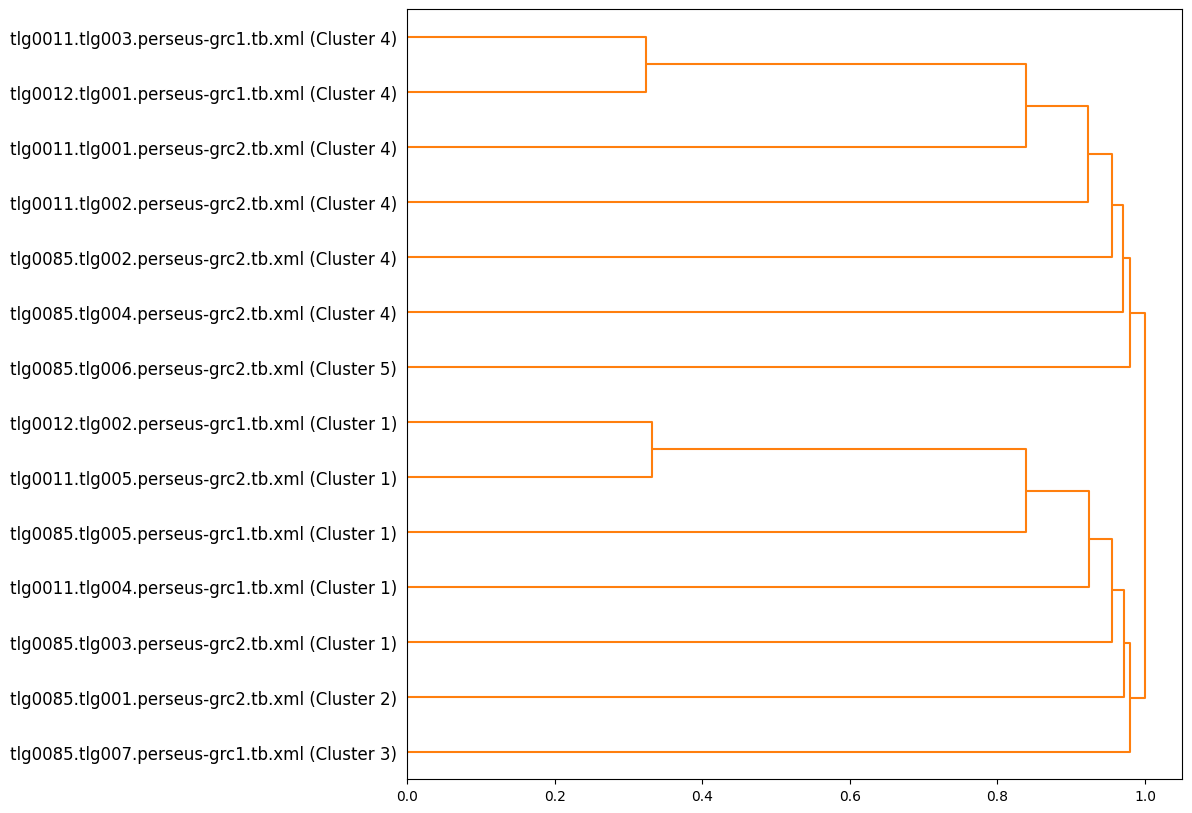

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

# Convertir la matrice de similarité en une matrice de dissimilarité
dissimilarity_matrix = 1 - similarity_matrix

# Assurez-vous que la diagonale est définie à 0
np.fill_diagonal(dissimilarity_matrix, 0)

# Générer la matrice de liaison
linkage_matrix = linkage(squareform(dissimilarity_matrix), method='ward')

# Déterminer les clusters en utilisant fcluster
cluster_ids = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Créer le dendrogramme
plt.figure(figsize=(10, 10))
dendrogram(linkage_matrix, labels=[f"{os.path.basename(label)} (Cluster {cluster_id})" for label, cluster_id in zip(all_files, cluster_ids)], orientation='right', color_threshold=num_clusters-0.5)
plt.show()
